# Modelling

## Packages

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import winsound
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import joblib

from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

from imblearn.over_sampling import SMOTE

from matplotlib import pyplot as plt

print(f" Found and Using {len(tf.config.experimental.list_physical_devices('GPU'))} GPU")

 Found and Using 1 GPU


## Functions

In [2]:
def scale_x_encode_y(x, y):

    #x_scaled = StandardScaler().fit_transform(x.values)    
    scaler_obj = StandardScaler()
    scaler_obj.fit(x.values)
    x_scaled = scaler_obj.transform(x.values)
    
    encoder = LabelEncoder()
    encoder.fit(y)
    y_encoded = encoder.transform(y)
    y_encoded = np_utils.to_categorical(y_encoded)
    
    y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
 
    return(x_scaled, y_encoded, y_map, scaler_obj)

def smote_data(x, y):
    oversample = SMOTE()
    smote_x, smote_y = oversample.fit_resample(x, y)

    return(smote_x, smote_y)

def split_data(df, divisor):
    df_tot = df.copy()
    print(f'df_tot count : {len(df_tot)}')

    df1 = df_tot.iloc[int(len(df_tot)/divisor):]
    print(f'df1 count : {len(df1)}')

    df2 = df_tot.iloc[:int(len(df_tot)/divisor)]
    print(f'df2 count : {len(df2)}')
    
    return(df_tot, df1, df2)

def data_prep(df, apply_smote = False):
    x = df.loc[:, df.columns != target_col]
    y = df[target_col]

    if apply_smote:
        x, y = smote_data(x, y)

    print(f'Record count : {len(y)}')
    print('--------------------------')
    print(y.value_counts())
    print('--------------------------')
    print(y.value_counts(normalize=True))
    
    x_scaled, y_encoded, y_map, scaler_obj = scale_x_encode_y(x, y)
    pd.DataFrame(x_scaled).head()
    
    return(x_scaled, y_encoded, y_map, scaler_obj)

## Read Data

In [3]:
df = pd.read_csv('data/tab_tick_2019.csv')
df.head(5)

,tick_avg,spread_avg,tick_sd,diff,avg_gain,avg_loss,rs,rsi,sema,sema_diff,...,ssma,ssma_diff,lsma,lsma_diff,sma_diff,max_tick,min_tick,max_gap,min_gap,direction
0,1.146322,0.000234,0.000011,-0.000009,0.000007,0.000010,0.726481,42.078708,1.146324,-1.855815e-07,...,1.146312,0.000003,1.146357,-0.000002,-0.000046,1.146361,1.146198,0.000039,-0.000124,same
1,1.146271,0.000306,0.000015,-0.000051,0.000007,0.000011,0.686985,40.722656,1.146319,-5.075611e-06,...,1.146315,0.000004,1.146353,-0.000005,-0.000037,1.146361,1.146224,0.000090,-0.000047,same
2,1.146260,0.000335,0.000007,-0.000011,0.000007,0.000012,0.597542,37.403846,1.146313,-5.639989e-06,...,1.146317,0.000002,1.146350,-0.000003,-0.000033,1.146361,1.146228,0.000101,-0.000032,same
3,1.146310,0.000254,0.000028,0.000050,0.000010,0.000012,0.881720,46.857143,1.146313,-3.143270e-07,...,1.146321,0.000004,1.146342,-0.000008,-0.000021,1.146361,1.146260,0.000052,-0.000050,same
4,1.146294,0.000307,0.000028,-0.000015,0.000010,0.000009,1.205882,54.666667,1.146311,-1.742447e-06,...,1.146319,-0.000002,1.146334,-0.000008,-0.000015,1.146361,1.146260,0.000067,-0.000035,same


In [4]:
target_col = 'direction'
x_scaled, y_encoded, y_map, scaler_obj = data_prep(df)
joblib.dump(scaler_obj, 'data/model/scaler_obj.pkl') 
joblib.dump(y_map, 'data/model/y_map.pkl') 

Record count : 49950
--------------------------
same        30019
increase    10026
decrease     9905
Name: direction, dtype: int64
--------------------------
same        0.600981
increase    0.200721
decrease    0.198298
Name: direction, dtype: float64


['data/model/y_map.pkl']

## Neural Network

### Network building

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(x_scaled, y_encoded,train_size = 0.8,random_state = 1)

In [6]:
model = Sequential([
    Dense(units = 32, activation='relu', input_shape=[len(train_x[0])]),
    Dense(units = 64, activation='relu'),
    Dense(units = 128, activation='relu'),
    Dense(units = 64, activation='relu'),
    Dense(units = 16, activation='relu'),
    Dense(units = 3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),    
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                736       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 20,515
Trainable params: 20,515
Non-trainable params: 0
____________________________________________________

### Training

In [7]:
epoch_val         = 10
batch_size_val    = 1024

verbose_val       = 2
workers_val       = -1

In [8]:
model.fit(x=train_x, 
          y=train_y, 
          epochs=epoch_val,
          batch_size = batch_size_val,
          validation_data = (valid_x, valid_y),
          workers= workers_val,
         verbose=verbose_val)

Epoch 1/10
40/40 - 1s - loss: 0.7050 - accuracy: 0.7403 - val_loss: 0.4749 - val_accuracy: 0.8029
Epoch 2/10
40/40 - 0s - loss: 0.4079 - accuracy: 0.8281 - val_loss: 0.4046 - val_accuracy: 0.8294
Epoch 3/10
40/40 - 0s - loss: 0.3708 - accuracy: 0.8430 - val_loss: 0.3792 - val_accuracy: 0.8427
Epoch 4/10
40/40 - 0s - loss: 0.3567 - accuracy: 0.8483 - val_loss: 0.3726 - val_accuracy: 0.8446
Epoch 5/10
40/40 - 0s - loss: 0.3508 - accuracy: 0.8506 - val_loss: 0.3701 - val_accuracy: 0.8421
Epoch 6/10
40/40 - 0s - loss: 0.3462 - accuracy: 0.8529 - val_loss: 0.3839 - val_accuracy: 0.8394
Epoch 7/10
40/40 - 0s - loss: 0.3430 - accuracy: 0.8550 - val_loss: 0.3562 - val_accuracy: 0.8502
Epoch 8/10
40/40 - 0s - loss: 0.3376 - accuracy: 0.8556 - val_loss: 0.3563 - val_accuracy: 0.8522
Epoch 9/10
40/40 - 0s - loss: 0.3369 - accuracy: 0.8555 - val_loss: 0.3550 - val_accuracy: 0.8520
Epoch 10/10
40/40 - 0s - loss: 0.3359 - accuracy: 0.8563 - val_loss: 0.3519 - val_accuracy: 0.8506


### DNN Validation

In [9]:
predictions = model.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.84      0.77      0.80      2007
    increase       0.82      0.81      0.81      1998
        same       0.86      0.89      0.88      5985

    accuracy                           0.85      9990
   macro avg       0.84      0.82      0.83      9990
weighted avg       0.85      0.85      0.85      9990



In [10]:
model.save('data/model/model.h5') 

model_new = load_model('data/model/model.h5')

### DNN Prediction

In [11]:
df1 = pd.read_csv('data/tab_tick_2018.csv')

#df1 = df1[col_list]
x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2017_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

Record count : 49950
--------------------------
same        23557
increase    13360
decrease    13033
Name: direction, dtype: int64
--------------------------
same        0.471612
increase    0.267467
decrease    0.260921
Name: direction, dtype: float64
              precision    recall  f1-score   support

    decrease       0.92      0.66      0.77     13033
    increase       0.92      0.67      0.77     13360
        same       0.71      0.94      0.81     23557

    accuracy                           0.79     49950
   macro avg       0.85      0.75      0.78     49950
weighted avg       0.82      0.79      0.79     49950



In [18]:
df1 = pd.read_csv('data/live_preds.csv')
df1 = df1.rename(columns = {'preds':'direction'})

In [19]:
df1.head()

,tick_avg,spread_avg,tick_sd,diff,avg_gain,avg_loss,rs,rsi,sema,sema_diff,...,lema_diff,lsma,lsma_diff,ema_diff,sma_diff,max_tick,min_tick,max_gap,min_gap,direction
0,1.228151,0.000072,0.000013,0.000034,0.000047,0.000019,2.500000,71.428571,1.227919,0.000033,...,0.000016,1.227824,0.000011,0.000073,0.000022,1.228151,1.227666,0.000000,-0.000485,increase
1,1.228179,0.000081,0.000032,0.000028,0.000049,0.000013,3.853556,79.396552,1.227951,0.000032,...,0.000016,1.227833,0.000010,0.000089,0.000037,1.228179,1.227666,0.000000,-0.000514,increase
2,1.228235,0.000083,0.000031,0.000055,0.000051,0.000013,3.966527,79.865206,1.227986,0.000036,...,0.000017,1.227842,0.000009,0.000108,0.000057,1.228235,1.227668,0.000000,-0.000567,increase
3,1.228381,0.000077,0.000028,0.000147,0.000057,0.000013,4.467225,81.709184,1.228034,0.000048,...,0.000023,1.227854,0.000012,0.000132,0.000079,1.228381,1.227668,0.000000,-0.000714,increase
4,1.228290,0.000073,0.000029,-0.000091,0.000050,0.000019,2.589269,72.139175,1.228067,0.000033,...,0.000018,1.227863,0.000009,0.000147,0.000100,1.228381,1.227668,0.000091,-0.000623,increase


In [22]:
df1.head()

,tick_avg,spread_avg,tick_sd,diff,avg_gain,avg_loss,rs,rsi,sema,sema_diff,...,lema_diff,lsma,lsma_diff,ema_diff,sma_diff,max_tick,min_tick,max_gap,min_gap,direction
0,1.228151,0.000072,0.000013,0.000034,0.000047,0.000019,2.500000,71.428571,1.227919,0.000033,...,0.000016,1.227824,0.000011,0.000073,0.000022,1.228151,1.227666,0.000000,-0.000485,increase
1,1.228179,0.000081,0.000032,0.000028,0.000049,0.000013,3.853556,79.396552,1.227951,0.000032,...,0.000016,1.227833,0.000010,0.000089,0.000037,1.228179,1.227666,0.000000,-0.000514,increase
2,1.228235,0.000083,0.000031,0.000055,0.000051,0.000013,3.966527,79.865206,1.227986,0.000036,...,0.000017,1.227842,0.000009,0.000108,0.000057,1.228235,1.227668,0.000000,-0.000567,increase
3,1.228381,0.000077,0.000028,0.000147,0.000057,0.000013,4.467225,81.709184,1.228034,0.000048,...,0.000023,1.227854,0.000012,0.000132,0.000079,1.228381,1.227668,0.000000,-0.000714,increase
4,1.228290,0.000073,0.000029,-0.000091,0.000050,0.000019,2.589269,72.139175,1.228067,0.000033,...,0.000018,1.227863,0.000009,0.000147,0.000100,1.228381,1.227668,0.000091,-0.000623,increase


In [29]:
df1['predictions'].value_counts()

increase    89
same        47
decrease    39
Name: predictions, dtype: int64

In [44]:
#df1 = pd.read_csv('data/tab_tick_2018.csv')

#df1 = df1[col_list]
x_scaled1, y_encoded1, y_map1, scaler_obj_1 = data_prep(df1, apply_smote = False)
y_map1 = {0: 'decrease', 1: 'same', 2: 'increase', }

predictions = model_new.predict(x_scaled1)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(y_encoded1, axis = -1)

df1['predictions'] = [y_map1[k] for k in rounded_predictions]
df1.to_csv('data/tab_tick_2017_res.csv')

print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map1.values()))

Record count : 175
--------------------------
increase    175
Name: direction, dtype: int64
--------------------------
increase    1.0
Name: direction, dtype: float64


ValueError: could not convert string to float: 'increase'

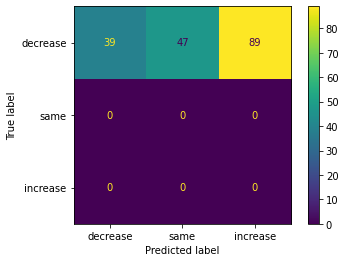

In [45]:
cm = confusion_matrix(rounded_valid_y, rounded_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_map1.values())
disp.plot() 

## RF Results

In [12]:
%%time
clf = RandomForestClassifier(n_jobs=-1) 
clf.fit(train_x, train_y)
predictions = clf.predict(valid_x)
rounded_predictions = np.argmax(predictions, axis = -1)
rounded_valid_y = np.argmax(valid_y, axis = -1)
print(classification_report(rounded_valid_y, rounded_predictions, target_names = y_map.values()))

              precision    recall  f1-score   support

    decrease       0.81      0.77      0.79      2007
    increase       0.84      0.78      0.81      1998
        same       0.86      0.90      0.88      5985

    accuracy                           0.85      9990
   macro avg       0.84      0.82      0.83      9990
weighted avg       0.85      0.85      0.85      9990

Wall time: 5.83 s


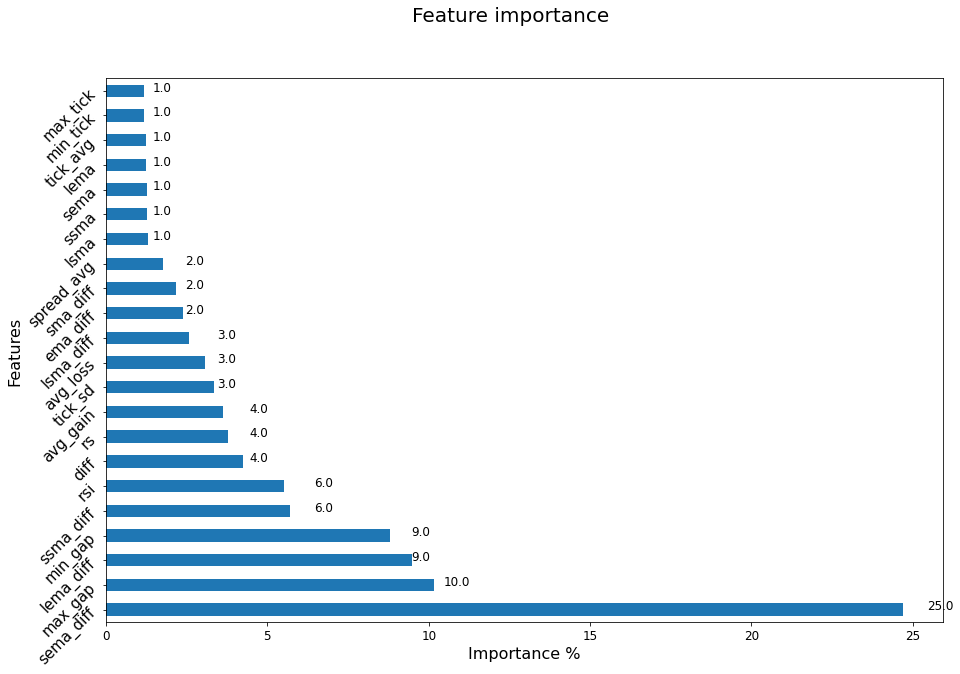

In [13]:
x_cols = df.columns[df.columns != 'direction']
fig = plt.figure()
fig.suptitle('Feature importance', fontsize=20)
plt.xlabel('Importance %', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=15)


feat_importances = pd.Series(clf.feature_importances_ * 100, index=x_cols)
feat_importances.nlargest(30).plot(kind='barh', figsize=(15, 10), rot=45)

for index, value in enumerate(np.round(-np.sort(-clf.feature_importances_ * 100))):
    plt.text(value+0.45, index, str(value), fontsize=12)